<a href="https://colab.research.google.com/github/disha2952/SimpleCV/blob/master/Face_mask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2
import os
from keras.utils import np_utils
import tensorflow as tf
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
images = []
targets = []

In [3]:
with_mask_path = '/content/drive/MyDrive/dataset/with_mask/'
without_mask_path = '/content/drive/MyDrive/dataset/without_mask/'

In [4]:
content = os.listdir(with_mask_path)
error_count = 1
for image in content:
    try:
        filename = with_mask_path + image
        img = cv2.imread(filename)
        img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        resized_img = cv2.resize(img_grey, (100, 100))
        images.append(resized_img)
        targets.append(0)
    except:
        print("filename Error", error_count)
        error_count += 1
print("Completed")

Completed


In [5]:
content = os.listdir(without_mask_path)
error_count = 1
for image in content:
    try:
        filename = without_mask_path + image
        img = cv2.imread(filename)
        img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        resized_img = cv2.resize(img_grey, (100, 100))
        images.append(resized_img)
        targets.append(1)
    except:
        print("filename Error", error_count)
        error_count += 1
print("Completed")

Completed


In [6]:
len(images), len(targets)

(1384, 1384)

In [7]:
images = np.array(images)/255.0
images = np.resize(images, (1384, 100, 100, 1))
targets = np_utils.to_categorical(targets)

In [8]:
targets

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(images, targets)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((1038, 100, 100, 1), (346, 100, 100, 1), (1038, 2), (346, 2))

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint

In [11]:
model = Sequential()

In [12]:
model.add(Conv2D(100, (3, 3), input_shape=(100, 100, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))    

model.add(Conv2D(100, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
cp = ModelCheckpoint('model-best', verbose=0, save_best_only=True)

In [14]:
model.fit(X_train, Y_train, epochs = 30, validation_split=0.2, callbacks = [cp])
model.save('saved_model/my_model.h5')

Epoch 1/30
26/26 [==============================] - 5s 60ms/step - loss: 0.8096 - accuracy: 0.5722 - val_loss: 0.5408 - val_accuracy: 0.7452
INFO:tensorflow:Assets written to: model-best/assets
Epoch 2/30
26/26 [==============================] - 1s 27ms/step - loss: 0.5464 - accuracy: 0.7320 - val_loss: 0.5284 - val_accuracy: 0.7692
INFO:tensorflow:Assets written to: model-best/assets
Epoch 3/30
26/26 [==============================] - 1s 28ms/step - loss: 0.4999 - accuracy: 0.7802 - val_loss: 0.4925 - val_accuracy: 0.7548
INFO:tensorflow:Assets written to: model-best/assets
Epoch 4/30
26/26 [==============================] - 1s 28ms/step - loss: 0.4184 - accuracy: 0.8231 - val_loss: 0.5277 - val_accuracy: 0.7788
Epoch 5/30
26/26 [==============================] - 1s 29ms/step - loss: 0.3049 - accuracy: 0.8760 - val_loss: 0.7156 - val_accuracy: 0.6202
Epoch 6/30
26/26 [==============================] - 1s 28ms/step - loss: 0.3089 - accuracy: 0.8863 - val_loss: 0.6521 - val_accuracy: 0.

In [15]:
predicted = model.evaluate(X_test, Y_test, verbose = 0)
print("Model Accuracy: {:.2f}%".format(predicted[1]*100))

Model Accuracy: 74.86%


In [18]:
from keras.models import load_model

In [19]:
mod = load_model('saved_model/my_model.h5')

In [20]:
face_detect = cv2.CascadeClassifier('/content/drive/MyDrive/haarcascade_frontalface_default.xml')

In [21]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

[[0.00455797 0.99544203]]


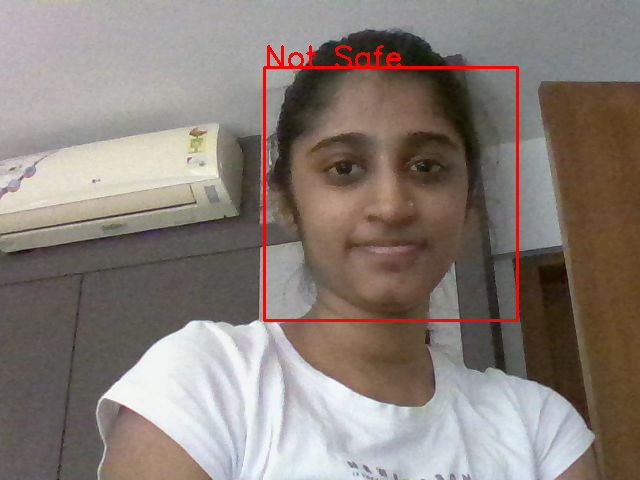

In [42]:
#image = cv2.imread(image_file, cv2.IMREAD_UNCHANGED)
image_file = take_photo()
image = cv2.imread(image_file)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
faces = face_detect.detectMultiScale(gray, 1.4, 5)
for (x, y, w, h) in faces:
  face_roi = gray[y:y+w, x:x+h]
  resize_image = cv2.resize(face_roi, (100, 100))
  normalized_image = resize_image/255.0
  reshaped_face = np.reshape(normalized_image, (1, 100, 100, 1))
  result = mod.predict(reshaped_face)
  print(result)
  if result[0][0] < result[0][1]:
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
    cv2.putText(image, "Not Safe", (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

  else:
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image, "Safe", (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
cv2_imshow(image)

<IPython.core.display.Javascript object>

[[0.6976179 0.3023821]]


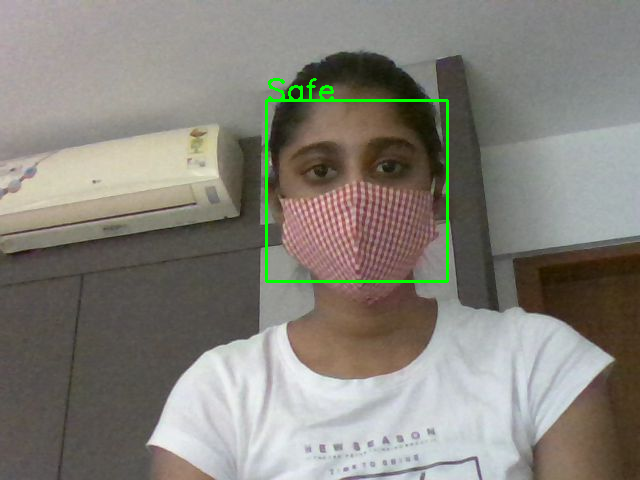

In [43]:
#image = cv2.imread(image_file, cv2.IMREAD_UNCHANGED)
image_file = take_photo()
image = cv2.imread(image_file)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
faces = face_detect.detectMultiScale(gray, 1.4, 5)
for (x, y, w, h) in faces:
  face_roi = gray[y:y+w, x:x+h]
  resize_image = cv2.resize(face_roi, (100, 100))
  normalized_image = resize_image/255.0
  reshaped_face = np.reshape(normalized_image, (1, 100, 100, 1))
  result = mod.predict(reshaped_face)
  print(result)
  if result[0][0] < result[0][1]:
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
    cv2.putText(image, "Not Safe", (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

  else:
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image, "Safe", (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
cv2_imshow(image)